In [1]:
import pandas as pd
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import missingno as msno
from datetime import timedelta
import os
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
import src.utils.utils as util   # 기타 유틸리티 모듈

from src.subjectlist_alignment import reintubation as rnt
from src.subjectlist_alignment import subject_classification as cls

In [2]:
data_dir = '../outputs/reintubation_df2.csv'

df = pd.read_csv(data_dir, index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
df = util.to_datetime(df, time_cols)
print(df.shape)
df.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9008, 20)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,reint_marker,intext_duration,reintubation_eventtime,reintubationtime,seq_num
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,False,2230.0,NaT,NaN,1
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,False,5419.0,NaT,NaN,1
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,['dischtime imputation'],False,3628.0,NaT,NaN,1
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,True,3930.0,2144-01-30 13:00:00,30.0,1
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,['dischtime imputation'],True,10005.0,NaT,NaN,2


<Axes: >

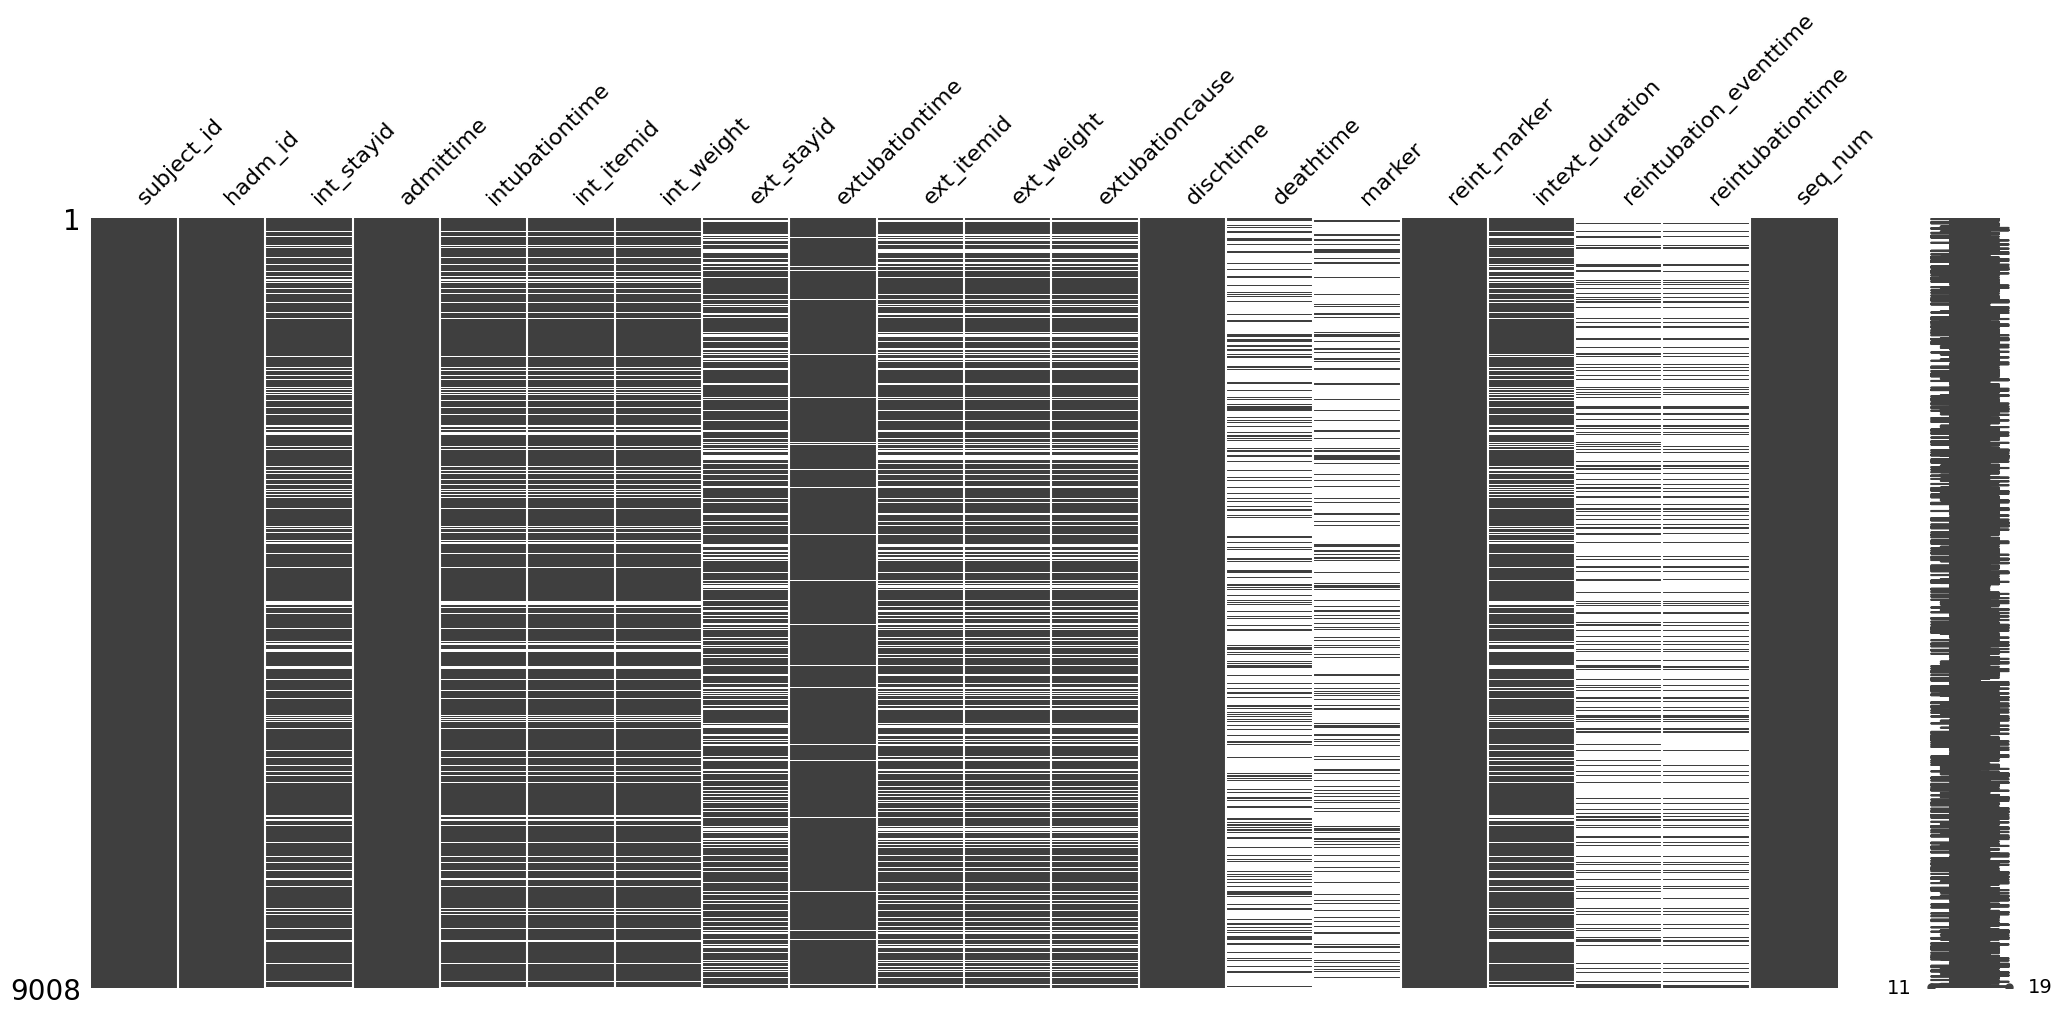

In [21]:
msno.matrix(df)

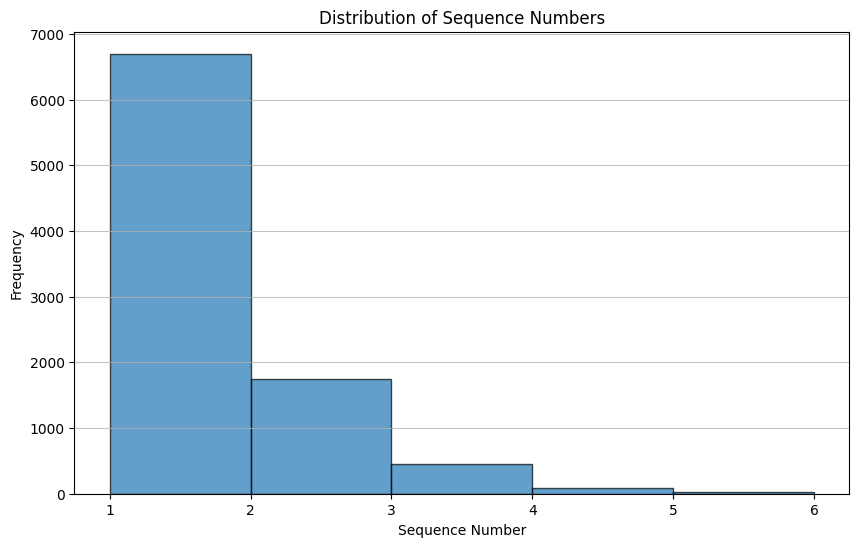

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(df['seq_num'], bins=range(1, df['seq_num'].max() + 1), edgecolor='k', alpha=0.7)
plt.title('Distribution of Sequence Numbers')
plt.xlabel('Sequence Number')
plt.ylabel('Frequency')
plt.xticks(range(1, df['seq_num'].max() + 1))
plt.grid(axis='y', alpha=0.75)

plt.show()

### 240202 test

In [6]:
def get_timediff(n1, n2):
    return n1 - n2

# # old ver
# def classify_reintubation(group):
#     subject_id = group.subject_id.unique()
#     hadm_id = group.hadm_id.unique()
#     id = (subject_id, hadm_id)

#     # 분기1: reintubation 여부 확인
#     cond_singleevent = (len(group) == 1)   # No: 삽관발관 이벤트가 1개인 경우 (no reintubation) -> 분기 1-1로 이동
#     cond_reintubation = (len(group) > 1)   # Yes: 복수의 삽관발관 이벤트가 있는 경우 (reintubation 존재) -> 분기 1-2로 이동

#     # 분기1-1: 퇴원시간 고려 (reintubation 없는 경우)
#     last_row = group.iloc[-1]
#     cond_disch_before_48 = get_timediff(last_row.dischtime, last_row.extubationtime) <= timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간 이내에 퇴원한 경우
#     cond_disch_after_48 = get_timediff(last_row.dischtime, last_row.extubationtime) > timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간이 넘어서 퇴원한 경우

#     # 분기1-1-1: 사망시간 고려 (reintubation 없는 경우)
#     last_row = group.iloc[-1]
#     last_extubationtime = last_row.extubationtime
#     last_dischtime = last_row.dischtime
#     last_deathtime = last_row.deathtime

#     cond_death_before_48 = get_timediff(last_row.deathtime, last_row.extubationtime) <= timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간 이내에 사망한 경우
#     cond_death_after_48 = (get_timediff(last_row.deathtime, last_row.extubationtime) > timedelta(hours=48)) | (pd.isna(last_row.deathtime))  # 마지막 삽관발관 이벤트 후 48시간이 넘어서 사망한 경우 (+ 사망시각 없는 경우)
#     cond_death = pd.notna(last_row.deathtime)

#     # (분기1-1-1-2: 사망시간 24시간 이내 고려)
#     cond_death_before_24 = get_timediff(last_row.deathtime, last_row.extubationtime) <= timedelta(hours=24)  # 마지막 삽관발관 이벤트 후 48시간 이내에 사망한 경우
    
#     # 분기2: reintubation 횟수 고려
#     cond_single_reint = (len(group) == 2)   # reintubation이 1번 이루어진 경우 (2행) -> 분기 2-1-1로 이동
#     cond_multi_reint = (len(group) > 2)   # reintubation이 여러번 이루어진 경우 (3행 이상) -> 분기 2-2-1로 이동

#     ## 분기2-1: 1번의 reintubation 시행한 케이스: 성공(48시간 이후) 실패(48시간 이내)
#     last_reintubationtime = group.iloc[0].reintubationtime  # reintubationtime은 앞의 행에 계산되어 있기 때문에 첫행 가져옴
#     cond_last_reint_after48 = last_reintubationtime > 48   # 성공 (reintubationtime 칼럼은 float이기 때문에 time delta 불필요)
#     cond_last_reint_before48 = last_reintubationtime <= 48   # 실패

#     # 분기2-1-2: 1번의 reintubation 시행 성공 후 사망 케이스 고려 (테스트 중)
#     cond_death = not pd.isnull(group.iloc[0].deathtime)    # deathtime이 존재하는지? 사망시간 있으면 true
    
#     # 조건: 재삽관1회 시행, 48시간 이후 (성공 케이스), 퇴원
#     lastext_to_disch_time_diff = get_timediff(last_dischtime, last_extubationtime)
#     lastext_to_death_time_diff = get_timediff(last_deathtime, last_extubationtime)

#     if (cond_reintubation) & (cond_single_reint) & (cond_last_reint_after48) & (lastext_to_disch_time_diff <= timedelta(48)) & (not cond_death):
#         return subject_id, hadm_id

#     # 분기2-2: 여러번의 reintubation 시행한 케이스 
#     if cond_reintubation:
#         second_last_row = group.iloc[-2]   # 여러번 중 마지막 재삽관 (중요: 마지막 reintubation은 데이터의 n-1 번째 행임. n 번째 행은 0으로 계산됨)
#         last_reintubationtime = second_last_row.reintubationtime
#         last_extubationtime = group.iloc[-1].extubationtime
#         last_dischtime = group.iloc[-1].dischtime
#         last_deathtime = group.iloc[-1].deathtime

#         cond_last_reint_after48 = last_reintubationtime > 48
#         cond_last_reint_before48 = last_reintubationtime <= 48

#         # 분기2-2-1: 최종 발관 이후 퇴원 케이스 고려
#         lastext_to_disch_time_diff = get_timediff(last_dischtime, last_extubationtime)
#         lastext_to_death_time_diff = get_timediff(last_deathtime, last_extubationtime)
#         cond_disch_before_48 = lastext_to_disch_time_diff <= timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간 이내에 퇴원한 경우
#         cond_disch_after_48 = lastext_to_disch_time_diff > timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간이 넘어서 퇴원한 경우
        
#         # 분기2-2-2: 최종 발관 이후 사망 케이스 고려
        
#         cond_death_before_48 = lastext_to_death_time_diff <= timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간 이내에 사망한 경우
#         cond_death_after_48 = lastext_to_death_time_diff > timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간이 넘어서 사망한 경우

#     # testing code
#     # if cond_reintubation & cond_single_reint & cond_reint_success:   # 총 한번의 삽관발관 이벤트 중 1개가 성공
#     #     print(f'subject: {subject_id}, SUCCESS.')
#     # elif cond_reintubation & cond_single_reint & cond_reint_failure: # 총 한번의 삽관발관 이벤트 중 1개가 실패
#     #     # print(f'subject: {subject_id}, FAILURE.')
#     #     pass

    
#     # Initialize a code variable, this will store the classification code
#     class_code = None

#     # Apply conditions and assign codes
#     if cond_singleevent:
#         if cond_disch_before_48:
#             # Condition: Single event and discharged before 48 hours
#             class_code = 'Code1'
#         elif cond_disch_after_48:
#             # Condition: Single event and discharged after 48 hours
#             class_code = 'Code2'

#     elif cond_reintubation:
#         if cond_single_reint:
#             # Conditions for single reintubation
#             if cond_last_reint_after48:
#                 class_code = 'Code3'
#             elif cond_last_reint_before48:
#                 class_code = 'Code4'
#         elif cond_multi_reint:
#             # Conditions for multiple reintubations
#             if cond_last_reint_after48:
#                 class_code = 'Code5'
#             elif cond_last_reint_before48:
#                 class_code = 'Code6'

#     # Assign the classification code to the group
#     # You can either add it as a new column in the group DataFrame or create a separate mapping
#     group['class_code'] = class_code

#     return group

def classify_null_case(group):
    """
    주어진 그룹 내에서 재삽관 실패 사례를 분류.
    """

    # 그룹이 단일 행만 포함하는 경우 함수 실행을 중단.
    if len(group) == 1:
        return group

    # 그룹 내의 각 행을 순회하며 조건에 따라 분류.
    for i in range(len(group) - 1):  # 마지막 행을 제외한 모든 행을 순회
        current_row = group.iloc[i]
        next_row = group.iloc[i + 1]

        # Scenario 1: 현재행의 'extubationtime'이 notnull이고 다음행의 'intubationtime'이 null일 경우
        if pd.notna(current_row['extubationtime']) and pd.isna(next_row['intubationtime']) and pd.notna(next_row['extubationtime']):
            time_diff = get_timediff(next_row['extubationtime'], current_row['extubationtime'])
            if time_diff <= timedelta(hours=48):   # 다음행 발관시간 - 현재행 발관시간 48시간 이내 사례 확인
                group.at[current_row.name, 'class_code'] = 999  # 실패로 분류

        # Scenario 2: 현재행의 'intubationtime'이 notnull이고 다음행의 'intubationtime'도 notnull일 경우
        if pd.notna(current_row['intubationtime']) and pd.isna(current_row['extubationtime']) and pd.notna(next_row['intubationtime']):
            time_diff = get_timediff(next_row['intubationtime'], current_row['intubationtime'])
            if time_diff <= timedelta(hours=48):   # 다음행 삽관시간 - 현재행 삽관시간 48시간 이내 사례 확인
                group.at[current_row.name, 'class_code'] = 998  # 실패로 분류

    return group


# ver2: 시간차 계산 함수 내부에서
def classify_reintubation(group):
    subject_id = group.subject_id.unique()
    hadm_id = group.hadm_id.unique()
    id = (subject_id, hadm_id)

    last_row = group.iloc[-1]

    # 분기1: reintubation 여부 확인
    cond_singleevent = (len(group) == 1)   # No: 삽관발관 이벤트가 1개인 경우 (no reintubation) -> 분기 1-1로 이동
    cond_reintubation = (len(group) > 1)   # Yes: 복수의 삽관발관 이벤트가 있는 경우 (reintubation 존재) -> 분기 1-2로 이동

    # 분기1-2: 퇴원 시간 확인 (발관 후 48시간 기준) - 행단위 적용 함수로 변환 필요
    cond_disch_after_48 = get_timediff(last_row.dischtime, last_row.extubationtime) > timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간이 넘어서 퇴원한 경우
    cond_disch_before_48 = get_timediff(last_row.dischtime, last_row.extubationtime) <= timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간 이내에 퇴원한 경우

    # 분기1-3: 사망 시간 확인 (발관 후 48시간 기준) - 행단위 적용 함수로 변환 필요
    cond_death_after_48 = (get_timediff(last_row.deathtime, last_row.extubationtime) > timedelta(hours=48)) | (pd.isna(last_row.deathtime))  # 마지막 삽관발관 이벤트 후 48시간이 넘어서 사망한 경우 (+ 사망시각 없는 경우)
    cond_death_before_48 = get_timediff(last_row.deathtime, last_row.extubationtime) <= timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간 이내에 사망한 경우
    
    # 분기1-4: 사망 시각 24시간 이내
    cond_death_before_24 = get_timediff(last_row.deathtime, last_row.extubationtime) <= timedelta(hours=24)  # 마지막 삽관발관 이벤트 후 24시간 이내에 사망한 경우
    

    # 재삽관 데이터 분류
    # 분기2-1: 재삽관 시간 확인
    # cond_reint_before48 = 


    # Initialize a code variable, this will store the classification code
    class_code = None

    # 재삽관 유무 확인
    if cond_singleevent:   # 재삽관 없음
        # 퇴원 확인
        if cond_disch_after_48:
            class_code = 11
        elif cond_disch_before_48:
            # class_code = 12

            # 사망시간 확인
            if cond_death_after_48:
                class_code = 121
            elif cond_death_before_48:
                class_code = 122
                if cond_death_before_24:   # 24시간 이내 사망 케이스
                    class_code = 1221
                else:
                    class_code = 1222
            # else:
            #     class_code = 129
        else:
            class_code = 9999  # intime, exttime 중 하나라도 null 값이 있는 경우 (inttime 결측일 가능성 높음)
    elif cond_reintubation:   # 재삽관 있음
        # class_code = 20
        pass



    # Assign the classification code to the group
    # You can either add it as a new column in the group DataFrame or create a separate mapping
    group['class_code'] = class_code

    return group



#     # 분기1-1: 퇴원시간 고려 (reintubation 없는 경우)
#     last_row = group.iloc[-1]
#     cond_disch_before_48 = get_timediff(last_row.dischtime, last_row.extubationtime) <= timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간 이내에 퇴원한 경우
#     cond_disch_after_48 = get_timediff(last_row.dischtime, last_row.extubationtime) > timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간이 넘어서 퇴원한 경우

#     # 분기1-1-1: 사망시간 고려 (reintubation 없는 경우)
#     last_row = group.iloc[-1]
#     last_extubationtime = last_row.extubationtime
#     last_dischtime = last_row.dischtime
#     last_deathtime = last_row.deathtime

#     cond_death_before_48 = get_timediff(last_row.deathtime, last_row.extubationtime) <= timedelta(hours=48)  # 마지막 삽관발관 이벤트 후 48시간 이내에 사망한 경우
#     cond_death_after_48 = (get_timediff(last_row.deathtime, last_row.extubationtime) > timedelta(hours=48)) | (pd.isna(last_row.deathtime))  # 마지막 삽관발관 이벤트 후 48시간이 넘어서 사망한 경우 (+ 사망시각 없는 경우)
#     cond_death = pd.notna(last_row.deathtime)

#     # (분기1-1-1-2: 사망시간 24시간 이내 고려)
#     cond_death_before_24 = get_timediff(last_row.deathtime, last_row.extubationtime) <= timedelta(hours=24)  # 마지막 삽관발관 이벤트 후 48시간 이내에 사망한 경우
    
#     # 분기2: reintubation 횟수 고려
#     cond_single_reint = (len(group) == 2)   # reintubation이 1번 이루어진 경우 (2행) -> 분기 2-1-1로 이동
#     cond_multi_reint = (len(group) > 2)   # reintubation이 여러번 이루어진 경우 (3행 이상) -> 분기 2-2-1로 이동

#     ## 분기2-1: 1번의 reintubation 시행한 케이스: 성공(48시간 이후) 실패(48시간 이내)
#     last_reintubationtime = group.iloc[0].reintubationtime  # reintubationtime은 앞의 행에 계산되어 있기 때문에 첫행 가져옴
#     cond_last_reint_after48 = last_reintubationtime > 48   # 성공 (reintubationtime 칼럼은 float이기 때문에 time delta 불필요)
#     cond_last_reint_before48 = last_reintubationtime <= 48   # 실패

#     # 분기2-1-2: 1번의 reintubation 시행 성공 후 사망 케이스 고려 (테스트 중)
#     cond_death = not pd.isnull(group.iloc[0].deathtime)    # deathtime이 존재하는지? 사망시간 있으면 true
    
#     # 조건: 재삽관1회 시행, 48시간 이후 (성공 케이스), 퇴원
#     lastext_to_disch_time_diff = get_timediff(last_dischtime, last_extubationtime)
#     lastext_to_death_time_diff = get_timediff(last_deathtime, last_extubationtime)

#     if (cond_reintubation) & (cond_single_reint) & (cond_last_reint_after48) & (lastext_to_disch_time_diff <= timedelta(48)) & (not cond_death):
#         return subject_id, hadm_id

#     # 분기2-2: 여러번의 reintubation 시행한 케이스 
#     if cond_reintubation:
#         second_last_row = group.iloc[-2]   # 여러번 중 마지막 재삽관 (중요: 마지막 reintubation은 데이터의 n-1 번째 행임. n 번째 행은 0으로 계산됨)
#         last_reintubationtime = second_last_row.reintubationtime
#         last_extubationtime = group.iloc[-1].extubationtime
#         last_dischtime = group.iloc[-1].dischtime
#         last_deathtime = group.iloc[-1].deathtime

#         cond_last_reint_after48 = last_reintubationtime > 48
#         cond_last_reint_before48 = last_reintubationtime <= 48

#         # 분기2-2-1: 최종 발관 이후 퇴원 케이스 고려
#         lastext_to_disch_time_diff = get_timediff(last_dischtime, last_extubationtime)
#         lastext_to_death_time_diff = get_timediff(last_deathtime, last_extubationtime)
#         cond_disch_before_48 = lastext_to_disch_time_diff <= timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간 이내에 퇴원한 경우
#         cond_disch_after_48 = lastext_to_disch_time_diff > timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간이 넘어서 퇴원한 경우
        
#         # 분기2-2-2: 최종 발관 이후 사망 케이스 고려
        
#         cond_death_before_48 = lastext_to_death_time_diff <= timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간 이내에 사망한 경우
#         cond_death_after_48 = lastext_to_death_time_diff > timedelta(hours=48)  # 마지막 발관 이벤트 후 48시간이 넘어서 사망한 경우

#     # testing code
#     # if cond_reintubation & cond_single_reint & cond_reint_success:   # 총 한번의 삽관발관 이벤트 중 1개가 성공
#     #     print(f'subject: {subject_id}, SUCCESS.')
#     # elif cond_reintubation & cond_single_reint & cond_reint_failure: # 총 한번의 삽관발관 이벤트 중 1개가 실패
#     #     # print(f'subject: {subject_id}, FAILURE.')
#     #     pass

    
#     # Initialize a code variable, this will store the classification code
#     class_code = None

#     # 재삽관 유무 확인
#     if cond_singleevent:
#         class_code = 10
#     elif cond_reintubation:
#         class_code = 20

#     # # Apply conditions and assign codes
#     # if cond_singleevent:
#     #     if cond_disch_before_48:
#     #         # Condition: Single event and discharged before 48 hours
#     #         class_code = 'Code1'
#     #     elif cond_disch_after_48:
#     #         # Condition: Single event and discharged after 48 hours
#     #         class_code = 'Code2'

#     # elif cond_reintubation:
#     #     if cond_single_reint:
#     #         # Conditions for single reintubation
#     #         if cond_last_reint_after48:
#     #             class_code = 'Code3'
#     #         elif cond_last_reint_before48:
#     #             class_code = 'Code4'
#     #     elif cond_multi_reint:
#     #         # Conditions for multiple reintubations
#     #         if cond_last_reint_after48:
#     #             class_code = 'Code5'
#     #         elif cond_last_reint_before48:
#     #             class_code = 'Code6'

#     # Assign the classification code to the group
#     # You can either add it as a new column in the group DataFrame or create a separate mapping
#     group['class_code'] = class_code

#     return group

In [3]:
# test code

grouped_df = df.groupby(['subject_id', 'hadm_id'])

processed_df_list = []
for _, group in grouped_df:
    group = cls.init_class_columns(group)   # ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
    group = cls.fill_class_columns(group)   # 초기화한 칼럼 값(ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
    group = cls.classify_patients(group)   # 분류해서 class_code 입력해주는 코드
    processed_df_list.append(group)

processed_df = pd.concat(processed_df_list)

In [6]:
processed_df.class_code.value_counts()

class_code
11      2926
997     1752
1221    1123
211     1089
121      844
212      717
9999     360
998       95
1222      54
999       48
Name: count, dtype: int64

In [25]:
processed_df[processed_df.class_code.isna()].reint_marker.unique()

array([ True])

<Axes: >

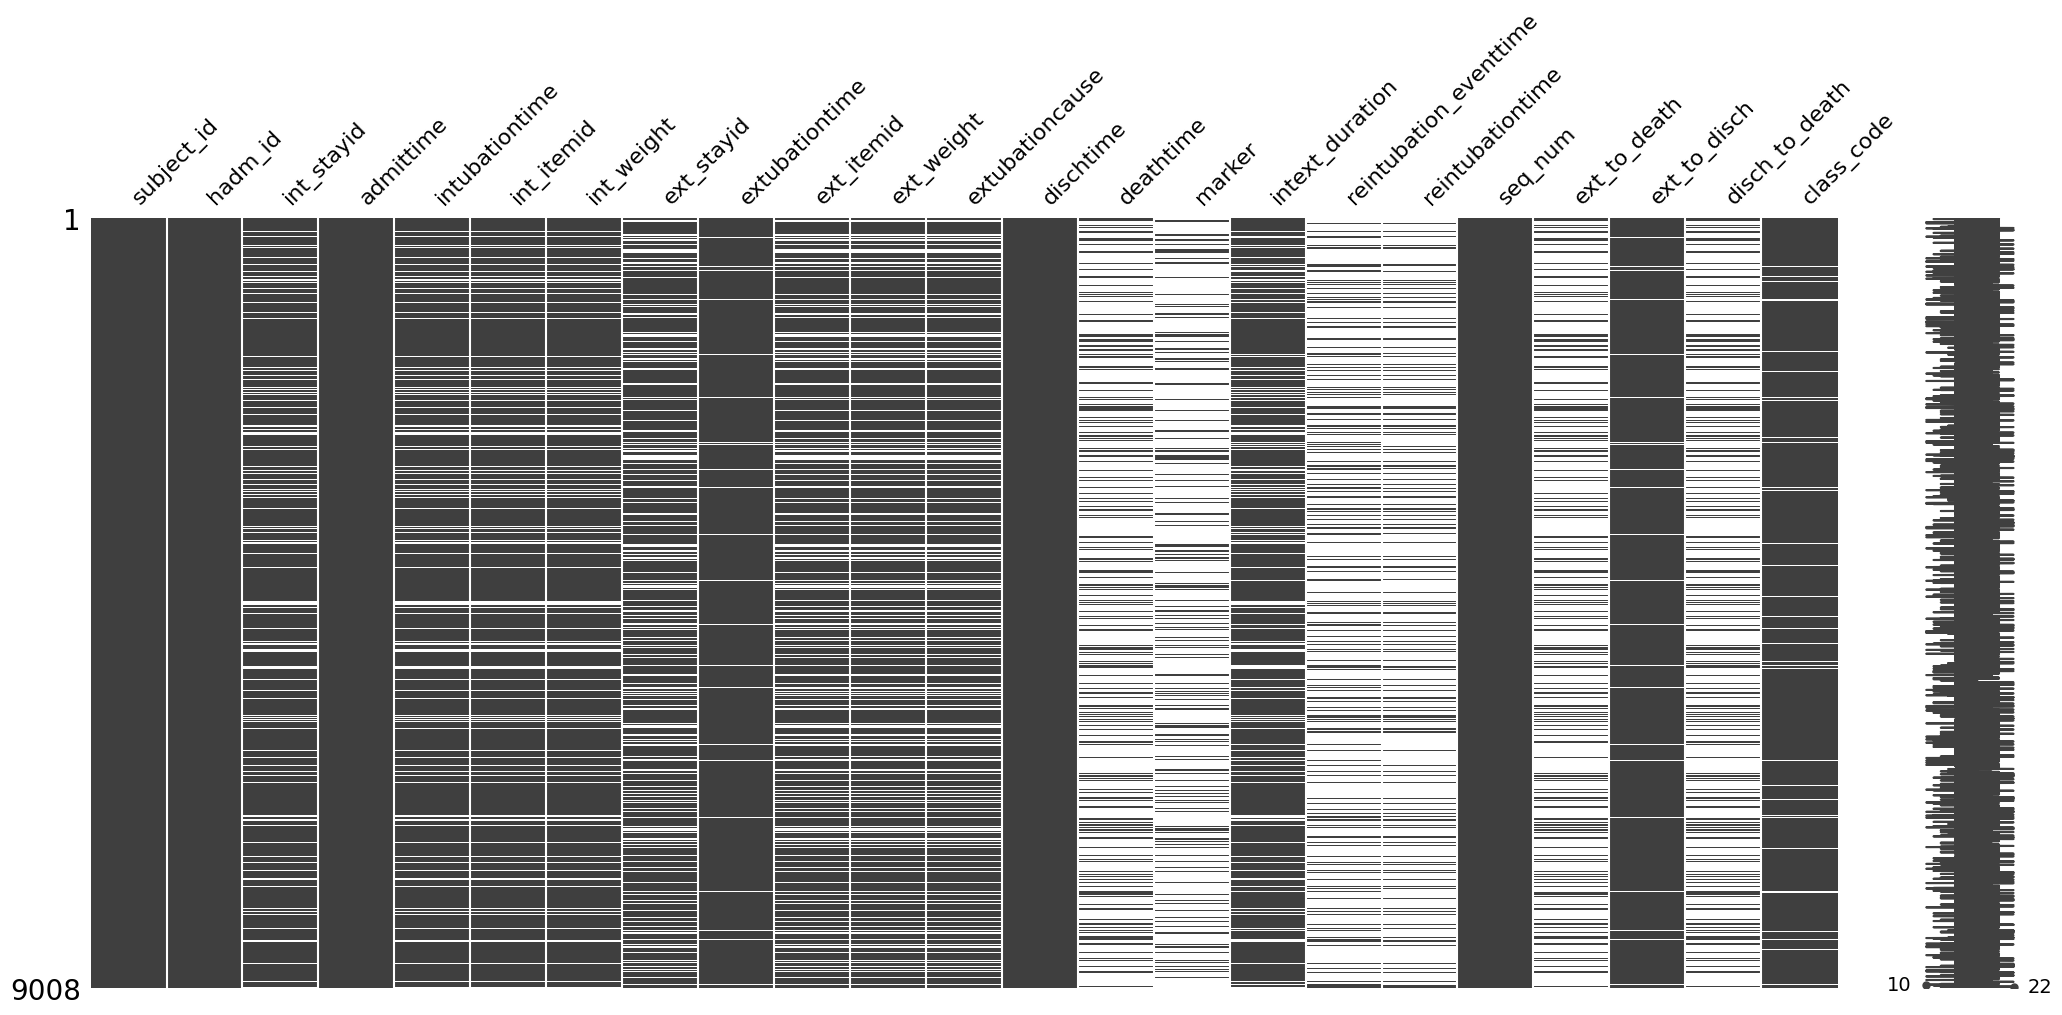

In [5]:
processed_df[processed_df.class_code == 1222]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,deathtime,marker,intext_duration,reintubation_eventtime,reintubationtime,seq_num,ext_to_death,ext_to_disch,disch_to_death,class_code
71,10104732,25159676,36035322.0,2184-07-22 23:33:00,2184-08-06 11:45:00,224385.0,51.1,36035322.0,2184-08-18 14:15:00,227194.0,...,2184-08-19 19:00:00,NaN,17430.0,NaT,NaN,1,1725.0,1725.0,0.0,1222
533,10599949,29510556,39425444.0,2165-12-02 14:52:00,2165-12-07 15:10:00,224385.0,37.0,39425444.0,2165-12-08 11:29:00,227194.0,...,2165-12-10 01:55:00,NaN,1219.0,NaT,NaN,1,2306.0,2306.0,0.0,1222
574,10667727,24639827,32530463.0,2152-01-06 18:39:00,2152-01-14 18:34:00,224385.0,81.0,32530463.0,2152-01-29 16:59:00,227194.0,...,2152-01-31 16:48:00,NaN,21505.0,NaT,NaN,1,2869.0,2869.0,0.0,1222
789,10864650,25070229,35720182.0,2156-08-08 01:44:00,2156-08-09 11:45:00,224385.0,87.2,35720182.0,2156-08-12 11:24:00,227194.0,...,2156-08-14 06:00:00,NaN,4299.0,NaT,NaN,1,2556.0,2556.0,0.0,1222
827,10909568,29114446,32806377.0,2154-10-14 21:22:00,2154-10-27 10:15:00,224385.0,82.0,32806377.0,2154-10-28 11:43:00,227194.0,...,2154-10-30 01:40:00,NaN,1528.0,NaT,NaN,1,2277.0,2277.0,0.0,1222
940,11018735,21052954,35153005.0,2196-02-05 00:16:00,2196-02-05 06:30:00,224385.0,52.5,35153005.0,2196-02-08 21:30:00,227194.0,...,2196-02-10 15:40:00,NaN,5220.0,NaT,NaN,1,2530.0,2530.0,0.0,1222
1005,11114467,21720678,34520382.0,2186-07-27 01:13:00,2186-07-29 08:00:00,224385.0,51.4,34520382.0,2186-07-29 15:17:00,227194.0,...,2186-07-30 19:46:00,NaN,437.0,NaT,NaN,1,1709.0,1709.0,0.0,1222
1133,11240116,21332084,32038591.0,2129-02-13 02:35:00,2129-02-20 12:23:00,224385.0,78.4,32038591.0,2129-02-22 13:50:00,227194.0,...,2129-02-23 21:30:00,NaN,2967.0,NaT,NaN,1,1900.0,1900.0,0.0,1222
1199,11309330,28783656,31759873.0,2113-02-04 14:25:00,2113-02-04 15:00:00,224385.0,79.0,31759873.0,2113-02-05 17:16:00,227194.0,...,2113-02-07 12:00:00,NaN,1576.0,NaT,NaN,1,2564.0,2564.0,0.0,1222
1201,11310752,25278913,38275000.0,2196-03-20 19:47:00,2196-03-21 13:50:00,224385.0,81.6,38275000.0,2196-03-22 12:55:00,227194.0,...,2196-03-24 01:35:00,NaN,1385.0,NaT,NaN,1,2200.0,2200.0,0.0,1222


In [42]:
# test code

grouped_df = df.groupby(['subject_id', 'hadm_id'])

processed_df_list = []
for _, group in grouped_df:
    group = classify_reintubation(group)
    processed_df_list.append(group)

processed_df = pd.concat(processed_df_list)

In [43]:
processed_df.class_code.value_counts()

classification_code
20     4061
11     2926
19     1428
122     474
121     119
Name: count, dtype: int64

In [65]:
(processed_df[processed_df.class_code == 20].reintubationtime <= 2880).sum()


1089

In [55]:
reint_df

3        True
4       False
12      False
13       True
14       True
        ...  
9000     True
9001    False
9002     True
9003     True
9004    False
Name: reintubationtime, Length: 4061, dtype: bool

In [32]:
len(df.hadm_id.unique())

6699

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,mvtime,reintubation_eventtime,reintubationtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,2230.0,NaT,NaN
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,5419.0,NaT,NaN
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,NaN,NaT,NaN
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,3930.0,2144-01-30 13:00:00,30.0
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,8416.0,2126-05-05 18:20:00,4430.0
9004,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,NaN,4269.0,NaT,NaN
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,NaN,4201.0,NaT,NaN
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,NaN,1155.0,NaT,NaN
